# 실구매 영수증기반 온라인쇼핑몰 연령별 매출 데이터

## 라이브러리 Import

In [1]:
# -*- coding: utf-8 -*-
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from glob import glob
from collections import Counter
from bokeh.models import DatetimeTickFormatter
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import ColumnDataSource, HoverTool, BoxAnnotation
from bokeh.palettes import Category10
from bokeh.layouts import layout
from bokeh.io.export import export_png

sys.path.append(os.path.abspath("../../code"))

import functions as fc

# pandas 설정
pd.set_option('display.max_columns', 100)

# matplotlib 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕 설정
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

In [2]:
data_path = os.path.abspath("../../data")
os.path.exists(data_path)

True

## 데이터 Load 및 살펴보기

In [3]:
file = f"{data_path}/raw/실 구매 영수증 기반 온라인 쇼핑몰 연령별 매출 데이터.xlsx"
df = pd.read_excel(file)
df.head()

,테이블순번,채널명,구매연도,구매분기,구매월,구매주차,구매주차일자,구매자연령,대분류,중분류,소분류,세분류,구매상품명,구매수량,구매금액
0,1,온라인쇼핑몰,Y2023,Q202304,M202310,W202340,20231002 ~ 20231008,40대,가공식품,제과,케익/빵,케익/빵,밀크앤허니 바질치즈치아바타샌드위치(780g/195g*4개입),1,13180
1,2,온라인쇼핑몰,Y2023,Q202304,M202310,W202340,20231002 ~ 20231008,40대,가공식품,소스/조미류,간장,간장,샘표 양조간장(701)(930ML),1,6400
2,3,온라인쇼핑몰,Y2023,Q202304,M202310,W202340,20231002 ~ 20231008,40대,가공식품,제과,초콜릿,초콜릿,허쉬 레귤러바 쿠키앤크림 40g 12개,1,12780
3,4,온라인쇼핑몰,Y2023,Q202304,M202310,W202340,20231002 ~ 20231008,40대,농산물,곡류,곡류,곡류,"미농 임금님 수라쌀 등급 상, 10kg, 1개",1,25900
4,5,온라인쇼핑몰,Y2023,Q202304,M202310,W202340,20231002 ~ 20231008,40대,농산물,두부/콩나물,두부,두부,"곰곰 콩두부, 500g, 8개",1,11830


In [4]:
# 채널명, 구매연도, 구매분기, 구매월 : Unique 값 1개
# 구매주차 : W202340 ~ W202443
# 구매주차일자 : 20231002 ~ 20231008, 20231009 ~ 20231015, 20231016 ~ 20231022, 20231023 ~ 20231029
# 구매자연령 : 30대 이하, 40대, 50대 이상
# 대분류 : 가공식품, 농산물, 수산물, 축산물, 델리, 반려동물용품

## 세분류 Value Counts

### 연령대 별 데이터셋

In [5]:
u30_df = df[df['구매자연령'] == '30대 이하']
o30u50_df = df[df['구매자연령'] == '40대']
o50_df = df[df['구매자연령'] == '50대 이상']

### 30대 이하 세분류 Value Counts

In [6]:
# 30대 이하 세분류 비율 계산 및 추가
u30_counts = u30_df.value_counts('세분류')
u30_ratio = u30_counts / u30_counts.sum() * 100
u30_df_with_ratio = pd.DataFrame({'count': u30_counts, 'ratio': u30_ratio})
u30_df_with_ratio

,count,ratio
세분류,,
채소,553,10.122643
건강기능식품,362,6.626396
비스켓/스낵,233,4.265056
과일,178,3.258283
라면,177,3.239978
...,...,...
청국장,2,0.036610
두부/콩나물(기타),2,0.036610
육포,2,0.036610


In [7]:
# u30_df_with_ratio.tail(86)의 count 총합과 ratio의 총합 계산
total_count = u30_df_with_ratio.tail(85)['count'].sum()
total_ratio = u30_df_with_ratio.tail(85)['ratio'].sum()

# 새로운 row 생성
new_row = pd.DataFrame({'count': [total_count], 'ratio': [total_ratio]}, index=['기타'])

# 기존 데이터프레임에 새로운 row 추가
result = pd.concat([u30_df_with_ratio.head(10), new_row])
u30_df_with_ratio = result

### 40대 세분류 Value Counts

In [8]:
# 40대 세분류 비율 계산 및 추가
o30u50_counts = o30u50_df.value_counts('세분류')
o30u50_ratio = o30u50_counts / o30u50_counts.sum() * 100
o30u50_df_with_ratio = pd.DataFrame({'count': o30u50_counts, 'ratio': o30u50_ratio})
o30u50_df_with_ratio

,count,ratio
세분류,,
채소,791,9.324531
과일,485,5.717317
라면,396,4.668160
건강기능식품,382,4.503124
비스켓/스낵,375,4.420606
...,...,...
담배,4,0.047153
두부/콩나물(기타),3,0.035365
양주,2,0.023577


In [9]:
# o30u50_df_with_ratio.tail(86)의 count 총합과 ratio의 총합 계산
total_count = o30u50_df_with_ratio.tail(86)['count'].sum()
total_ratio = o30u50_df_with_ratio.tail(86)['ratio'].sum()

# 새로운 row 생성
new_row = pd.DataFrame({'count': [total_count], 'ratio': [total_ratio]}, index=['기타'])

# 기존 데이터프레임에 새로운 row 추가
result = pd.concat([o30u50_df_with_ratio.head(10), new_row])
o30u50_df_with_ratio = result


### 50대 이상 세분류 Value Counts

In [10]:
o50_counts = o50_df.value_counts('세분류')
o50_ratio = o50_counts / o50_counts.sum() * 100
o50_df_with_ratio = pd.DataFrame({'count': o50_counts, 'ratio': o50_ratio})
o50_df_with_ratio

,count,ratio
세분류,,
채소,183,7.987778
과일,159,6.940201
라면,128,5.587080
건강기능식품,105,4.583151
우유,98,4.277608
...,...,...
육포,2,0.087298
유아식(기타),2,0.087298
축산통조림,1,0.043649


In [11]:
# o50_df_with_ratio.tail(86)의 count 총합과 ratio의 총합 계산
total_count = o50_df_with_ratio.tail(76)['count'].sum()
total_ratio = o50_df_with_ratio.tail(76)['ratio'].sum()

# 새로운 row 생성
new_row = pd.DataFrame({'count': [total_count], 'ratio': [total_ratio]}, index=['기타'])

# 기존 데이터프레임에 새로운 row 추가
result = pd.concat([o50_df_with_ratio.head(10), new_row])
o50_df_with_ratio = result

### 연령대별 세분류 PIE Chart

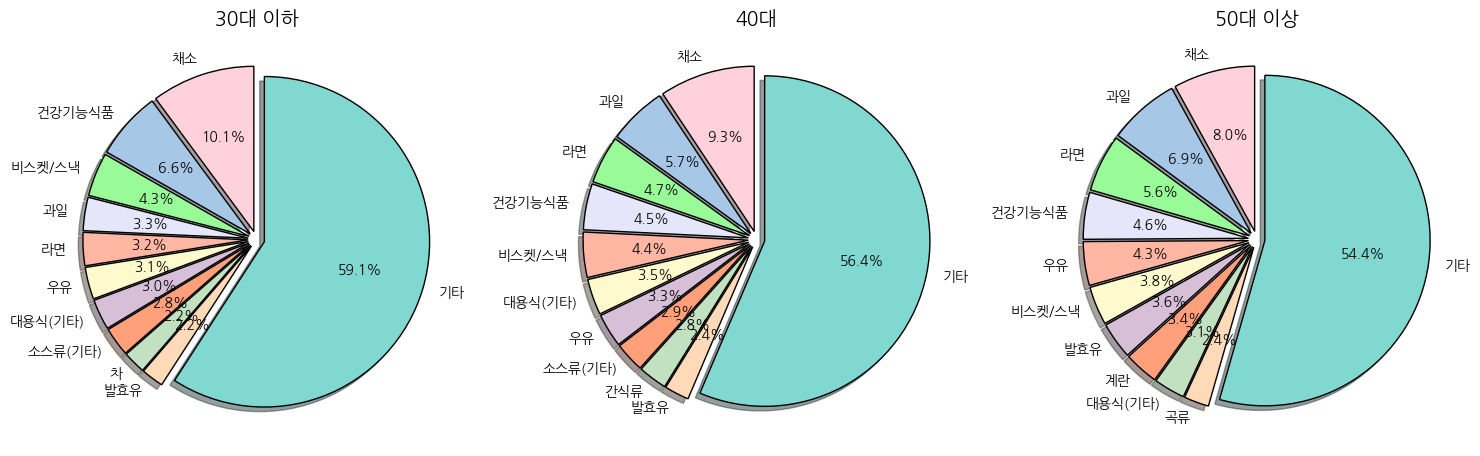

In [12]:
# 색상 설정
colors = ["#FFD1DC", "#A7C7E7", "#98FB98", "#E6E6FA", "#FFB6A3",
          "#FFFACD", "#D8BFD8", "#FFA07A", "#C1E1C1", "#FFDAB9", "#81D8D0"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 30대 이하 원형차트
axes[0].pie(u30_df_with_ratio['ratio'], labels=u30_df_with_ratio.index, autopct='%1.1f%%',
            startangle=90, colors=colors, shadow=True, explode=[0.05] * len(u30_df_with_ratio),
            wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[0].set_title('30대 이하', fontsize=14, fontweight='bold')

# 40대 원형차트
axes[1].pie(o30u50_df_with_ratio['ratio'], labels=o30u50_df_with_ratio.index, autopct='%1.1f%%',
            startangle=90, colors=colors, shadow=True, explode=[0.05] * len(o30u50_df_with_ratio),
            wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1].set_title('40대', fontsize=14, fontweight='bold')

# 50대 이상 원형차트
axes[2].pie(o50_df_with_ratio['ratio'], labels=o50_df_with_ratio.index, autopct='%1.1f%%',
            startangle=90, colors=colors, shadow=True, explode=[0.05] * len(o50_df_with_ratio),
            wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[2].set_title('50대 이상', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


- 실구매 영수증기반 온라인쇼핑몰 연령별 매출 데이터 기준
- 2030세대 채소, 건강기능식품 구매비율이 상대적으로 높은편
- => 직장인 대상으로 하여 건강식/간편식/도시락 저당 비스켓판매
- => 만개의 레시피 재료 추출
- => 가격 변동성, MoM 체크
- => 창업자 설득 방안 제시 ( 순수익 계산 등등... )


In [13]:
u30_df_with_ratio

,count,ratio
채소,553,10.122643
건강기능식품,362,6.626396
비스켓/스낵,233,4.265056
과일,178,3.258283
라면,177,3.239978
우유,171,3.130148
대용식(기타),163,2.983709
소스류(기타),154,2.818964
차,121,2.214900
발효유,120,2.196595


In [14]:
u30_df_with_ratio[u30_df_with_ratio.index != "기타"]

,count,ratio
채소,553,10.122643
건강기능식품,362,6.626396
비스켓/스낵,233,4.265056
과일,178,3.258283
라면,177,3.239978
우유,171,3.130148
대용식(기타),163,2.983709
소스류(기타),154,2.818964
차,121,2.214900
발효유,120,2.196595


## 구매상품명 Word Counts

### Word Counts 진행 결과
- 대분류별 구매상품명 Word Counts는 Filtering 해야하는 단어들이 너무 많음.
- 세분류 Top5의 구매상품명만 Word Counts를 진행해도 충분할 것으로 보임.
- 세분류 Top5 : 채소, 건강기능식품, 비스켓/스낵, 과일, 라면(x)

### 대분류 별 데이터셋 및 건수 확인

In [15]:
processed_df = df[df['대분류'] == '가공식품']
agricultural_df = df[df['대분류'] == '농산물']
livestock_df = df[df['대분류'] == '축산물']
fishery_df = df[df['대분류'] == '수산물']
deli_df = df[df['대분류'] == '델리']

# print(df['대분류'].value_counts())
print('가공식품 주문 건수 : ', len(processed_df), '건', '(', round(len(processed_df) / len(df) * 100, 2), ' %)')
print('농산물 주문 건수 : ', len(agricultural_df), '건', '(', round(len(agricultural_df) / len(df) * 100, 2), ' %)')
print('축산물 주문 건수 : ', len(livestock_df), '건', '(', round(len(livestock_df) / len(df) * 100, 2), ' %)')
print('수산물 주문 건수 : ', len(fishery_df), '건', '(', round(len(fishery_df) / len(df) * 100, 2), ' %)')
print('델리 주문 건수 : ', len(deli_df), '건', '(', round(len(deli_df) / len(df) * 100, 2), ' %)')

가공식품 주문 건수 :  11235 건 ( 69.19  %)
농산물 주문 건수 :  3040 건 ( 18.72  %)
축산물 주문 건수 :  988 건 ( 6.08  %)
수산물 주문 건수 :  452 건 ( 2.78  %)
델리 주문 건수 :  80 건 ( 0.49  %)


### Word Counts 함수

In [16]:
def most_frequent_words(dataframe, column_name, num_words=10, filter_words=None):
    all_words = ' '.join(str(item) for item in dataframe[column_name] if pd.notna(item))
    word_counts = Counter(all_words.split())

    if filter_words:
        filtered_words = set(filter_words)
        words_to_remove = set()
        for word, count in word_counts.items():
            if word in filtered_words:
                words_to_remove.add(word)
            elif any(filtered_word in word for filtered_word in filtered_words):
                words_to_remove.add(word)

        for word in words_to_remove:
            if word in word_counts:
              del word_counts[word]

    return word_counts.most_common(num_words)

In [17]:
words_to_filter = ['kg', 'ml', '0구', '인증', '팩', '세트', 'ML', 'mL', 'g', 'G', '냉장', '냉동', '호주산', '곰곰', '등급', '개', '+', 'x', 'X', '1',
                   '오뚜기', '청정원', '농심', '유기농', '풀무원', '오리지널', '맛있는', '삼립', '오리온', '프리미엄', '샘표', '서울', '대상',
                   '상하목장', '골드', '무라벨', '미니', '60정', '매일유업', '남양', '올리브', '해표', '국내산', '친환경', 'GAP', '못생겨도',
                   '한끼', '햇', '혼합', '무농약', '국산', '당도선별', '무항생제', '한돈', '90정', '30정', '옛날', '강아지', '고양이',
                   '홍홍', '더', 'L', '아이배냇', '중국식품', '컵', '만든', '앤', '고소한', '간식', '맑은물에', '조인', '팔도', '가농', '고소한', '신선한']

### 가공식품 Word Counts

In [18]:
# 가공식품 Word Counts
p_top_words = most_frequent_words(processed_df, '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(p_top_words, columns=['word', 'frequency'])

,word,frequency
0,우유,212
1,플레인,199
2,요거트,135
3,맥심,97
4,닭가슴살,85
5,동원,82
6,제로,80
7,켈로그,78
8,진라면,77
9,해태제과,75


### 농산물 Word Counts

In [19]:
# 농산물 Word Counts
a_top_words = most_frequent_words(agricultural_df, '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(a_top_words, columns=['word', 'frequency'])

,word,frequency
0,감자,66
1,바나나,53
2,양파,46
3,만나다,42
4,두부,40
5,애호박,40
6,햅쌀,39
7,샐러드,39
8,제스프리,37
9,사과,37


### 축산물 Word Counts

In [20]:
# 축산물 Word Counts
l_top_words = most_frequent_words(livestock_df, '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(l_top_words, columns=['word', 'frequency'])

,word,frequency
0,소고기,105
1,구이용,90
2,대란,71
3,하림,69
4,삼겹살,67
5,특란,61
6,동물복지,58
7,앞다리살,47
8,국거리용,46
9,다짐육,42


### 수산물 Word Counts

In [21]:
# 수산물 Word Counts
f_top_words = most_frequent_words(fishery_df, '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(f_top_words, columns=['word', 'frequency'])

,word,frequency
0,오징어,25
1,새우살,19
2,도시락김,16
3,구운,15
4,흰다리,15
5,광천김,15
6,자른,14
7,손질,13
8,아라찬,13
9,3p,12


### Deli Word Counts

In [22]:
# Deli Word Counts
d_top_words = most_frequent_words(deli_df, '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(d_top_words, columns=['word', 'frequency'])

,word,frequency
0,크로크,6
1,강남밥상,6
2,김자반,5
3,메추리알,5
4,장조림,5
5,야미요밀,4
6,정성가득,4
7,채식,4
8,동보식품,4
9,정성을,4


### 전체 Words Counts

In [23]:
# 전체 Word Counts
total_top_words = most_frequent_words(df, '구매상품명', num_words=30, filter_words=words_to_filter)
pd.DataFrame(total_top_words, columns=['word', 'frequency'])

,word,frequency
0,우유,212
1,플레인,199
2,요거트,142
3,소고기,142
4,닭가슴살,110
5,하림,107
6,사과,103
7,맥심,97
8,동원,95
9,구이용,94


### 30대 이하 Words Counts

In [24]:
# 전체 Word Counts
u30_top_words = most_frequent_words(df[df['구매자연령'] == '30대 이하'], '구매상품명', num_words=25, filter_words=words_to_filter)
df_u30 = pd.DataFrame(u30_top_words, columns=['30_word', '30_frequency'])

### 40대 Words Counts

In [25]:
# 전체 Word Counts
o30u50_top_words = most_frequent_words(df[df['구매자연령'] == '40대'], '구매상품명', num_words=25, filter_words=words_to_filter)
df_o30u50 = pd.DataFrame(o30u50_top_words, columns=['40_word', '40_frequency'])

### 50대 이상 Words Counts

In [26]:
# 전체 Word Counts
o50_top_words = most_frequent_words(df[df['구매자연령'] == '50대 이상'], '구매상품명', num_words=25, filter_words=words_to_filter)
df_o50 = pd.DataFrame(o50_top_words, columns=['50_word', '50_frequency'])

### 연령대별 Word Counts 결과

In [27]:
merged_df = pd.concat([df_u30, df_o30u50, df_o50], axis=1)
merged_df

,30_word,30_frequency,40_word,40_frequency,50_word,50_frequency
0,우유,82,우유,94,플레인,48
1,플레인,69,플레인,82,우유,36
2,요거트,60,소고기,69,동물복지,27
3,소고기,55,진라면,60,하림,27
4,닭가슴살,42,토마토,58,닭가슴살,26
5,구이용,40,요거트,58,요거트,24
6,제로,39,동원,56,저지방,21
7,사과,33,맥심,54,폰타나,20
8,동원,33,하림,52,복음자리,19
9,맥심,32,사과,52,사과,18


### 세분류별 Word Counts ( 채소 )

In [28]:
veg_top_words = most_frequent_words(df[df['세분류'] == '채소'], '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(veg_top_words, columns=['word', 'frequency'])

,word,frequency
0,감자,66
1,양파,46
2,애호박,40
3,샐러드,39
4,백오이,35
5,양배추,31
6,브로콜리,30
7,"감자,",29
8,파프리카,27
9,양상추,27


### 세분류별 Word Counts ( 건강기능식품 )

In [29]:
health_top_words = most_frequent_words(df[df['세분류'] == '건강기능식품'], '구매상품명', num_words=10, filter_words=words_to_filter)
pd.DataFrame(health_top_words, columns=['word', 'frequency'])

,word,frequency
0,비타민,50
1,멀티비타민,42
2,유산균,38
3,루테인,37
4,플러스,34
5,오메가3,33
6,알티지,32
7,뉴트리디데이,31
8,다이어트,31
9,프로바이오틱스,30


# 소비 분석 카테고리 데이터 (장보고 마트)

In [30]:
import duckdb

con = duckdb.connect()
query = """
SELECT *
FROM read_parquet([
    '/content/drive/MyDrive/data/jbg_parquet/TB_CL_MTH_SALES_YMD_20230301_01n.parquet',
    '/content/drive/MyDrive/data/jbg_parquet/TB_CL_MTH_SALES_YMD_20230301_02n.parquet',
    '/content/drive/MyDrive/data/jbg_parquet/TB_CL_MTH_SALES_YMD_20230301_03n.parquet',
    '/content/drive/MyDrive/data/jbg_parquet/TB_CL_MTH_SALES_YMD_20230301_04n.parquet'
])
"""
df = con.execute(query).df()

IOException: IO Error: No files found that match the pattern "/content/drive/MyDrive/data/jbg_parquet/TB_CL_MTH_SALES_YMD_20230301_01n.parquet"

In [159]:
df['fdmt_pdlt_lgls_nm'].value_counts()

,count
fdmt_pdlt_lgls_nm,
가공상품,4272799
농산물,2390899
비식품,924216
축산물,539648
수산물,362491
프랜차이즈,3237


In [160]:
df = df[df['fdmt_pdlt_lgls_nm'].isin(['가공상품', '농산물', '수산물', '축산물'])]

In [161]:
df = df[['cfmtn_ymd', 'fdmt_pdlt_lgls_nm', 'fdmt_pdlt_mdcl_nm', 'fdmt_pdlt_smcs_nm', 'fdmt_pdlt_nm', 'tot_sle_qyt']]

In [164]:
df[df['fdmt_pdlt_lgls_nm'] == '가공상품']['fdmt_pdlt_smcs_nm'].value_counts().head(10)

,count
fdmt_pdlt_smcs_nm,
과자류,331831
두부,174368
어묵류,170187
즉석면류,167097
빵류,159934
요구르트,120996
우유,112083
탄산음료,106688
소주,91853


In [ ]:
df['fdmt_pdlt_smcs_nm'].value_counts().head(10)

In [ ]:
df[df['fdmt_pdlt_mdcl_nm'] == '구근류']['fdmt_pdlt_smcs_nm'].value_counts()

In [ ]:
df['fdmt_pdlt_mdcl_nm'].value_counts()

# 만개의 레시피 데이터

In [128]:
recipe = pd.read_excel('/content/drive/MyDrive/data/레시피/TB_RECIPE_SEARCH-20231130.xlsx')

## 데이터 정제

### 필요한 컬럼만 추출

In [149]:
df = recipe[['RCP_SNO', 'CKG_NM', 'INQ_CNT', 'RCMM_CNT', 'SRAP_CNT', 'CKG_MTRL_CN', 'CKG_INBUN_NM', 'CKG_TIME_NM']]

### 요리명 지정(Target)하여 데이터 추출

In [151]:
cond1 = df['CKG_NM'].str.contains('샐러드')
cond2 = df['CKG_NM'].str.contains('연어')
target = df[cond1 & cond2]

### Target 데이터의 Score 컬럼 생성

- Score : ( 조회수 / 조회수 최댓값 ) + ( 추천수 / 추천수 최댓값 ) + ( 스크랩수 / 스크랩수 최댓값 )

In [155]:
target['SCORE'] = (target['INQ_CNT']/target['INQ_CNT'].max()) + (target['RCMM_CNT']/target['RCMM_CNT'].max()) + (target['SRAP_CNT']/target['SRAP_CNT'].max())

### Score 순으로 Target 데이터 추출

In [156]:
target.sort_values('SCORE', ascending=False).head(10)

,RCP_SNO,CKG_NM,INQ_CNT,RCMM_CNT,SRAP_CNT,CKG_MTRL_CN,CKG_INBUN_NM,CKG_TIME_NM,SCORE
31025,6834136,연어샐러드,91233,72,1827,[재료] 훈제연어 적당량| 양파 1/2개| 양상추 1줌| 케이퍼 [양념] 홀스래디쉬...,1인분,10분이내,2.301985
36040,6840533,양상추연어샐러드,74984,30,2088,[재료] 훈제연어 슬라이스 1팩| 크래미 8개| 양파 1개| 양상추 1/2통 [양념...,4인분,60분이내,1.767604
58975,6871972,훈제연어샐러드,73536,65,854,[필수재료] 훈제연어 1팩| 양상추 1/4개| 어린잎채소 1줌 [소스재료] 마요네즈...,4인분,10분이내,1.655942
16027,4750135,연어샐러드,213668,10,947,[재료] 냉장연어| 샐러드채소| 방울토마토 [양념] 마요네즈 5큰술| 머스타드 1작...,2인분,10분이내,1.592433
15896,4709629,훈제연어야채샐러드,82860,17,1678,[재료] 훈제연어 슬라이스 12장| 양상추 2~3잎| 베이비채소 적당량| 양파 1/...,2인분,60분이내,1.427549
81513,6899785,연어샐러드,84503,0,1440,[재료] 좋아하는야채| 연어 [레몬요거트소스] 레몬청 3t| 마요네즈 6| 요거트 ...,1인분,10분이내,1.085143
34733,6838575,연어샐러드,34798,35,588,[재료] 훈제연어 2팩| 샐러드야채 1/2팩| 파프리카 1/2개| 오리엔탈드레싱| 케이퍼,2인분,10분이내,0.930580
14398,4354519,훈제연어샐러드,58237,6,979,[재료] 겨자잎 3장| 적치커리 3장| 로메인 3장| 양상추 3장| 당근 1/4| ...,1인분,10분이내,0.824761
20603,6304708,훈제연어샐러드,57837,18,524,[재료] 훈제연어 180g| 양상추| 치커리| 양파| 방울토마토| 블랙올리브| 크루...,2인분,30분이내,0.771644
34603,6838424,연어샐러드,33885,25,394,[재료] 동원연어콜드스모크 로즈마리앤 페퍼(140g) 2팩| 양상추 잎 4-5장| ...,2인분,30분이내,0.694507


### Score 1등 요리의 재료 데이터 추출

In [157]:
print(target['CKG_MTRL_CN'].iloc[0])

[재료] 양상추| 돈나물| 계란 5개| 훈제연어 1팩 [양념] 소금 0.3작은술| 아일랜드 드레싱 1팩
